
** NAMED ENTITY RECOGNITION FOR CONLL-2003 (ENGLISH) SHARED TASK USING CHARACTER-LEVEL EMBEDDINTGS**

# Importing Libraries

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd

import numpy as np
np.random.seed(0)
plt.style.use("ggplot")
import tensorflow as tf
print('Tensorflow version:', tf.__version__)
print('GPU detected:', tf.config.list_physical_devices('GPU'))

Tensorflow version: 2.4.1
GPU detected: []


# Reading of Datasets

In [ ]:
train = pd.read_csv ('train.txt',delimiter=' ')
train.to_csv ('new_train.csv', index=None)
valid = pd.read_csv ('valid.txt',delimiter=' ')
valid.to_csv ('new_valid.csv', index=None)
test = pd.read_csv ('test.txt',delimiter=' ')
test.to_csv ('new_test.csv', index=None)

# Preprocessing of Data

In [ ]:
train.head()

,-DOCSTART-,-X-,-X-.1,O
0,EU,NNP,B-NP,B-ORG
1,rejects,VBZ,B-VP,O
2,German,JJ,B-NP,B-MISC
3,call,NN,I-NP,O
4,to,TO,B-VP,O


In [ ]:
len(train)

204566

In [ ]:
valid.head()

,-DOCSTART-,-X-,-X-.1,O
0,CRICKET,NNP,B-NP,O
1,-,:,O,O
2,LEICESTERSHIRE,NNP,B-NP,B-ORG
3,TAKE,NNP,I-NP,O
4,OVER,IN,B-PP,O


In [ ]:
len(valid)

51577

In [ ]:
test.head()

,-DOCSTART-,-X-,-X-.1,O
0,SOCCER,NN,B-NP,O
1,-,:,O,O
2,JAPAN,NNP,B-NP,B-LOC
3,GET,VB,B-VP,O
4,LUCKY,NNP,B-NP,O


In [ ]:
len(test)

46665

Filling of missing data in the datasets

In [ ]:
t_data = train.fillna(method="ffill")
v_data = valid.fillna(method="ffill")
ts_data = test.fillna(method="ffill")

Printing the number of unique words and tags in the datasets

In [ ]:
print("Unique words in train corpus:", t_data['-DOCSTART-'].nunique())
print("Unique tags in train corpus:", t_data['O'].nunique())

print("Unique words in valid corpus:", v_data['-DOCSTART-'].nunique())
print("Unique tags in valid corpus:", v_data['O'].nunique())

print("Unique words in test corpus:", ts_data['-DOCSTART-'].nunique())
print("Unique tags in test corpus:", ts_data['O'].nunique())

Unique words in train corpus: 23623
Unique tags in train corpus: 9
Unique words in valid corpus: 9966
Unique tags in valid corpus: 9
Unique words in test corpus: 9489
Unique tags in test corpus: 9


Creating the list of unique words in the datasets

In [ ]:
t_unique_words = list(set(t_data["-DOCSTART-"].values))
num_words_t = len(t_unique_words)

v_unique_words = list(set(v_data["-DOCSTART-"].values))
num_words_v = len(v_unique_words)

ts_unique_words = list(set(ts_data["-DOCSTART-"].values))
num_words_ts = len(ts_unique_words)

Creating the list of unique tags 

In [ ]:
tags = list(set(t_data["O"].values))
num_tags = len(tags)
num_tags

9

Creating the lists of labels in a datasets

In [ ]:
train_labels = t_data['O']
valid_labels = v_data['O']
test_labels=ts_data['O']

Creating the list of words in a datasets

In [ ]:
t_listed_words = list(t_data['-DOCSTART-'].values)
v_listed_words = list(v_data['-DOCSTART-'].values)
ts_listed_words = list(ts_data['-DOCSTART-'].values)

Converting the dataframe into the list of tuples

In [ ]:
def intotuple(s):
    tup = [(w, p, c, t) for w, p, c, t in zip(s["-DOCSTART-"].values.tolist(),
                                                           s["-X-"].values.tolist(), s["-X-.1"].values.tolist(),
                                                           s["O"].values.tolist())]
    return tup

In [ ]:
train=intotuple(t_data)
val=intotuple(v_data)
test=intotuple(ts_data)

Creating the word2idx, idx2word,tag2idx and idx2tag to map the every  unique word to an index and to map every unique tag to an index vice versa

In [ ]:
word2idx = {w: i  for i, w in enumerate(t_unique_words+v_unique_words+ts_unique_words)}
tag2idx = {t: i for i, t in enumerate(tags)}
idx2word = {i: w for w, i in word2idx.items()}
idx2tag = {i: w for w, i in tag2idx.items()}

Creating the list of unique characters

In [ ]:
chars = set([c for w in t_unique_words for c in w])
n_chars = len(chars)
print(n_chars)

84


Creating the char2idx to map every unique character to index


In [ ]:
char2idx = {c: i + 1 for i, c in enumerate(chars)}
char2idx["PAD"] = 0

Plotting the length of words in training set

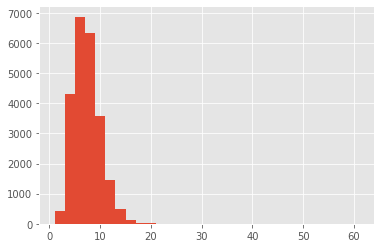

In [ ]:
plt.hist([len(w) for w in t_unique_words],bins=30)
plt.show()

Plotting the length of words in the validation set

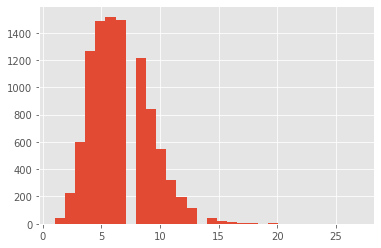

In [ ]:
plt.hist([len(w) for w in v_unique_words],bins=30)
plt.show()

Plotting the length of words in the test set

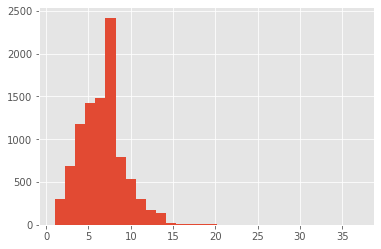

In [ ]:
plt.hist([len(w) for w in ts_unique_words],bins=30)
plt.show()

Taking the maximum length of words for padding

In [ ]:
max_len_char = 20

Creating the 2-D list having mapped with indexes for every character of words in a sentences with padding

In [ ]:
def char_padding(data):
    X_char = []
    for i in range(len(data)):
        for word in data[i][0]:
            word_char=[]
            for j in range(max_len_char):
                try:
                    word_char.append(char2idx.get(data[i][0][j],0))
                except:
                    word_char.append(char2idx.get("PAD"))
        X_char.append(np.array(word_char))
    return X_char

In [ ]:
X_train_char = char_padding(train)
X_valid_char = char_padding(val)
X_test_char = char_padding(test)

# Training

Importing the model layers

In [ ]:
from keras.models import Model, Input
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Conv1D
from keras.layers import Bidirectional, concatenate, SpatialDropout1D, GlobalMaxPooling1D

Architecture of model

In [ ]:
# Input and embeddings for characters
char_in = Input(shape=(1, max_len_char,))
emb_char = TimeDistributed(Embedding(input_dim=n_chars + 1, output_dim=15,
                           input_length=max_len_char, mask_zero=True))(char_in)
# Character LSTM to get word encodings by characters
char_enc = TimeDistributed(Bidirectional(LSTM(units=20, return_sequences=False,
                                recurrent_dropout=0.5)))(emb_char)

# Main LSTM
x = SpatialDropout1D(0.5)(char_enc)
main_lstm = Bidirectional(LSTM(units=100, return_sequences=True,
                               recurrent_dropout=0.5))(x)
main_lstm = Dense(200,activation='relu')(main_lstm)
main_lstm = Dropout(0.5)(main_lstm)
out = TimeDistributed(Dense(num_tags, activation="softmax"))(main_lstm)

model = Model([char_in], out)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1, 20)]           0         
_________________________________________________________________
time_distributed (TimeDistri (None, 1, 20, 15)         1275      
_________________________________________________________________
time_distributed_1 (TimeDist (None, 1, 40)             5760      
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 1, 40)             0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 1, 200)            112800    
_________________________________________________________________
dense (Dense)                (None, 1, 200)            40200     
_________________________________________________________________
dropout (Dropout)            (None, 1, 200)            0     

Compiling the model

In [ ]:
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["acc"])

In [ ]:
pip install livelossplot

Note: you may need to restart the kernel to use updated packages.


Importing the module from libraries for Checkpoints, EarlyStopping and for Plotting of acuracy and loss curve for training and validation set

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from livelossplot import PlotLossesKeras

Training of model on training set and evaluating on validation set

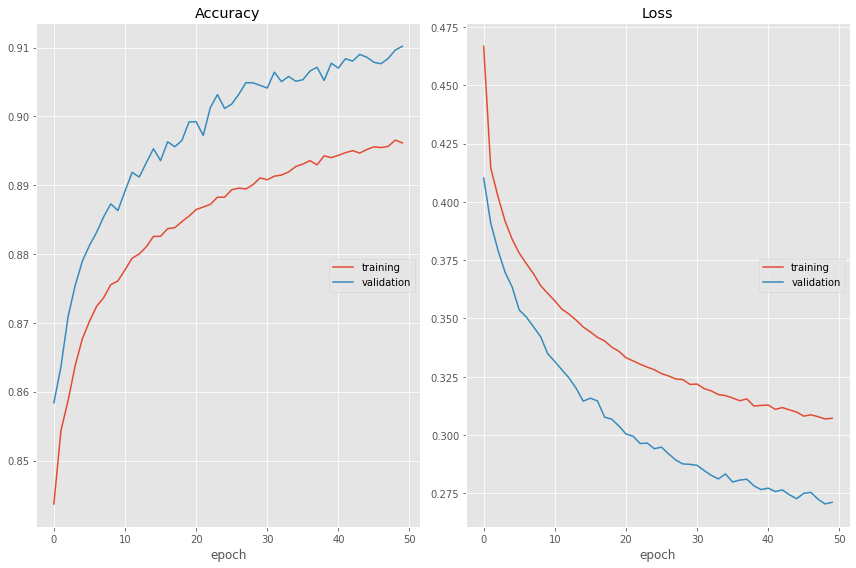

Accuracy
	training         	 (min:    0.844, max:    0.897, cur:    0.896)
	validation       	 (min:    0.858, max:    0.910, cur:    0.910)
Loss
	training         	 (min:    0.307, max:    0.467, cur:    0.307)
	validation       	 (min:    0.270, max:    0.410, cur:    0.271)

Epoch 00050: val_loss did not improve from 0.27041
CPU times: user 7h 21min 31s, sys: 16h 43min 17s, total: 1d 4min 48s
Wall time: 2h 10min 39s


In [ ]:
%%time

chkpt = ModelCheckpoint("model_weights.h5", monitor='val_loss',verbose=1, save_best_only=True, save_weights_only=True, mode='min')

early_stopping = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=1, verbose=0, mode='max', baseline=None, restore_best_weights=False)

callbacks = [PlotLossesKeras(), chkpt, early_stopping]

history = model.fit(
    x=np.array(X_train_char).reshape((len(X_train_char), 1, max_len_char)),
    y=np.array(Y_train).reshape(len(Y_train), 1, 1),
    validation_data=(np.array(X_valid_char).reshape((len(X_valid_char),1, max_len_char)),
                     np.array(Y_valid).reshape(len(Y_valid), 1, 1)),
    batch_size=64, 
    epochs=50,
    callbacks=[callbacks],
    verbose=1
)

# Prediction on Test Set

Predicting the probabilities of tags for the test set

In [ ]:
y_pred = model.predict(np.asarray(X_test_char).astype('int32').reshape((len(X_test_char),1, max_len_char)))

# Performance Metrices

Importing the module for metrices used for NER  

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report,confusion_matrix

Converting the predicted probabalities of labels into the tags

In [ ]:
idx2tag = {i: w for w, i in tag2idx.items()}

def pred2label(pred):
    out = []
    for pred_i in pred:
        out_i = []
        for p in pred_i:
            p_i = np.argmax(p)
            out_i.append(idx2tag[p_i].replace("PAD", "O"))
        out.append(out_i)
    return out

In [ ]:
pred_labels = pred2label(y_pred)

Converting the indexed tags of true labels into tags

In [ ]:
def true2label(true_l):
    out = []
    for i in true_l:
        out.append(idx2tag[i])
    return out

In [ ]:
test_labels = true2label(Y_test)

Calculating the F1-score for the test set

In [ ]:
print("F1-score: {:.1%}".format(f1_score(np.asarray(test_labels).reshape(-1,1),np.asarray(pred_labels).reshape(-1,1),average='micro')))

F1-score: 89.3%


Classification Report of the test set

In [ ]:
print(classification_report(np.asarray(test_labels).reshape(-1,1),np.asarray(pred_labels).reshape(-1,1)))

              precision    recall  f1-score   support

       B-LOC       0.66      0.67      0.67      1672
      B-MISC       0.67      0.55      0.61       706
       B-ORG       0.49      0.28      0.36      1663
       B-PER       0.39      0.73      0.51      1620
       I-LOC       0.55      0.25      0.34       258
      I-MISC       0.82      0.39      0.53       216
       I-ORG       0.39      0.20      0.27       836
       I-PER       0.31      0.20      0.24      1158
           O       0.97      0.99      0.98     38536

    accuracy                           0.89     46665
   macro avg       0.58      0.47      0.50     46665
weighted avg       0.89      0.89      0.89     46665



Confusion matrix of test set

In [ ]:
print(confusion_matrix(test_labels, pred_labels))

[[ 1128    13   111   195     5     2     8    80   130]
 [   39   390    37    66     5     1    12    25   131]
 [  271    65   469   368     3     6    70   160   251]
 [   66    28    67  1176    10     1    20   155    97]
 [   38     8     4    45    65     0    38    21    39]
 [    1    17     6    31     1    84    12     6    58]
 [   64    18    60   207    23     4   169    36   255]
 [   50    17   112   654     6     1    19   229    70]
 [   40    25    87   289     1     4    87    30 37973]]
